Unlike other machine learning algorithms, long short-term memory recurrent neural networks are capable of automatically learning features from sequence data, support multiple-variate data, and can output a variable length sequences that can be used for multi-step forecasting. 

- How to develop and evaluate Univariate and multivariate Encoder-Decoder LSTMs for multi-step time series forecasting.
- How to develop and evaluate an CNN-LSTM Encoder-Decoder model for multi-step time series forecasting.
- How to develop and evaluate a ConvLSTM Encoder-Decoder model for multi-step time series forecasting.


## 20.1 Tutorial Overview
This tutorial is divided into nine parts; they are: 
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. LSTMs for Multi-step Forecasting
5. Univariate Input and Vector Output
6. Encoder-Decoder LSTM With Univariate Input
7. Encoder-Decoder LSTM With Multivariate Input
8. CNN-LSTM Encoder-Decoder With Univariate Input 
9. ConvLSTM Encoder-Decoder With Univariate Input

## 20.2 Problem Description

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. 

- global active power: The total active power consumed by the household (kilowatts).
- global reactive power: The total reactive power consumed by the household (kilowatts). 􏰀 voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: Active energy for kitchen (watt-hours of active energy).
- sub metering 2: Active energy for laundry (watt-hours of active energy).
- sub metering 3: Active energy for climate control systems (watt-hours of active energy).


Active and reactive energy refer to the technical details of alternative current. A fourth sub-metering variable can be created by subtracting the sum of three defined sub-metering variables from the total active energy. 

## 20.3 Load and Prepare Dataset

## 20.4 Model Evaluation

We must update the framework for model evaluation, specifically the walk-forward validation method used to fit a LSTM model and make a forecast. Refer to Chapter 19 for the details of the development of the new walk-forward validation framework for evaluating deep learning models on this problem.

## 20.5 LSTMs for Multi-step Forecasting


- Vanilla LSTM: model with vector output for multi-step forecasting with univariate input data.
- Encoder-Decoder LSTM: model for multi-step forecasting with univariate input data.
- Encoder-Decoder LSTM: model for multi-step forecasting with multivariate input data.
- CNN-LSTM Encoder-Decoder: model for multi-step forecasting with univariate input data.
- ConvLSTM Encoder-Decoder: model for multi-step forecasting with univariate input data.

## 20.6 Univariate Input and Vector Output


We will start off by developing a simple or vanilla LSTM model that reads in a sequence of days of total daily power consumption and predicts a vector output of the next standard week of daily power consumption. 

Some ideas on the size and nature of this input include:
- All prior days, up to years worth of data. 􏰀 
- The prior seven days.
- The prior two weeks.
- The prior one month.
- The prior one year.
- The prior week and the week to be predicted from one year ago.

There is no right answer; instead, each approach and more can be tested and the performance of the model can be used to choose the nature of the input that results in the best model performance. These choices define a few things:
- How the training data must be prepared in order to fit the model.
- How the test data must be prepared in order to evaluate the model.
- How to use the model to make predictions with a final model in the future.

An LSTM model expects data to have the shape: [samples, timesteps, features]. One sample will be comprised of seven time steps with one feature for the seven days of total daily power consumed. The training dataset has 159 weeks of data, so the shape of the training dataset would be: [159, 7, 1].

A problem is that 159 instances is not a lot to train a neural network. A way to create a lot more training data is to change the problem during training to predict the next seven days given the prior seven days, regardless of the standard week. 

Input, 　　　　　　　　　　　　　　　Output<br>
[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14] <br>
[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]<br>

When we run this function on the entire training dataset, we transform 159 samples into 1,099; specifically, the transformed dataset has the shapes X=[1099, 7, 1] and y=[1099, 7].

We will develop a model with a single hidden LSTM layer with 200 units. The number of units in the hidden layer is unrelated to the number of time steps in the input sequences. The LSTM layer is followed by a fully connected layer with 200 nodes that will interpret the features learned by the LSTM layer. Finally, an output layer will directly predict a vector with seven elements, one for each day in the output sequence. 

lstm: [402.944] 424.1, 405.1, 396.1, 411.0, 407.3, 335.5, 433.9


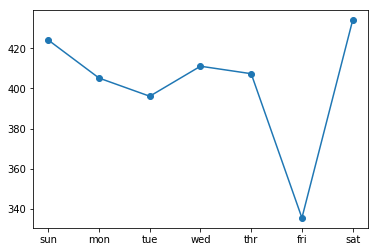

In [2]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline 

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Running the example fits and evaluates the model, printing the overall RMSE across all seven days, and the per-day RMSE for each lead time. We can see that in this case, the model was skillful as compared to a naive forecast, achieving an overall RMSE of about 399 kilowatts, less than 465 kilowatts achieved by a naive model.

We can increase the number of prior days to use as input from seven to 14 by changing the n input variable.

lstm: [373.392] 376.1, 388.8, 345.6, 382.0, 369.4, 312.8, 428.5


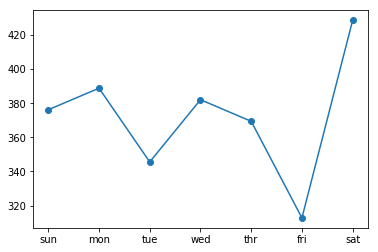

In [3]:
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Re-running the example with this change first prints a summary of performance of the model. In this case, we can see a further drop in the overall RMSE to about 370 kilowatts, suggesting that further tuning of the input size and perhaps the number of nodes in the model may result in better performance.

Comparing the per-day RMSE scores we see some are better and some are worse than using seven-day inputs. This may suggest benefit in using the two different sized inputs in some way, such as an ensemble of the two approaches or perhaps a single model (e.g. a multi-headed model) that reads the training data in different ways.

## 20.7 Encoder-Decoder LSTM With Univariate Input

In this section, we can update the vanilla LSTM to use an encoder-decoder model. The model will be comprised of two sub models, the encoder to read and encode the input sequence, and the decoder that will read the encoded input sequence and make a one-step prediction for each element in the output sequence.

1. Define encoder: we define an LSTM hidden layer with 200 units. This is the decoder model that will read the input sequence and will output a 200 element vector (one output per unit) that captures features from the input sequence. 

2. We will use a simple encoder-decoder architecture that is easy to implement in Keras, that has a lot of similarity to the architecture of an LSTM autoencoder. First, the internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence. This sequence of vectors will be presented to the LSTM decoder.

3. We then define the decoder as an LSTM hidden layer with 200 units. Importantly, the decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the seven days, representing the basis for what to predict for each day in the output sequence.

4. We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer. Importantly, the output layer predicts a single step in the output sequence, not all seven days at a time. This means that we will use the same layers applied to each step in the output sequence. It means that the same fully connected layer and output layer will be used to process each time step provided by the decoder. To achieve this, we will wrap the interpretation layer and the output layer in a TimeDistributed wrapper that allows the wrapped layers to be used for each time step from the decoder.

5.  The network therefore outputs a three-dimensional vector with the same structure as the input, with the dimensions [samples, timesteps, features]. There is a single feature, the daily total power consumed, and there are always seven features. A single one-week prediction will therefore have the size: [1, 7, 1]. Therefore, when training the model, we must restructure the output data (y) to have the three-dimensional structure instead of the two-dimensional structure of [samples, features] used in the previous section.

RepeatVector <br>
keras.layers.RepeatVector(n) <br>
Repeats the input n times. <br>

In [ ]:
plot_model(model, show_shapes=True, to_file='multiheaded_Encoder-Decoder.png', show_layer_names=True)

lstm: [382.551] 379.1, 401.4, 342.3, 375.1, 376.5, 313.8, 470.7


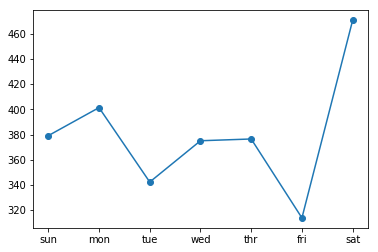

In [10]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]\
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='multiheaded_Encoder-Decoder.png', show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

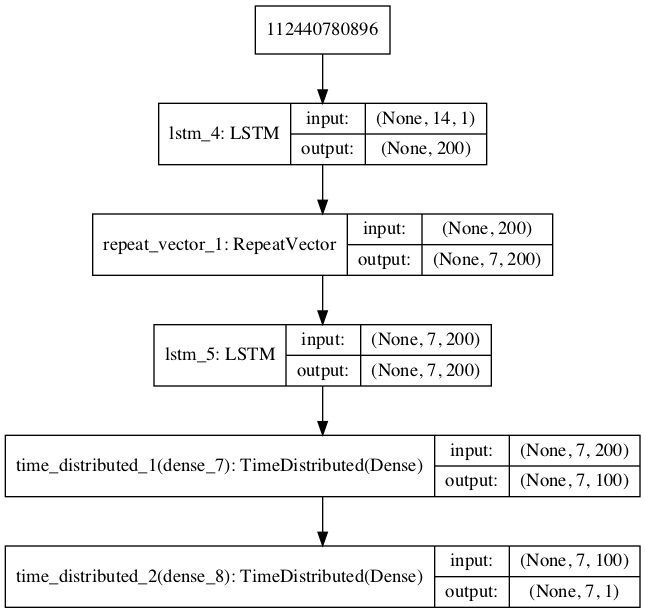

In [11]:
from IPython.display import Image
Image(retina=True, filename='multiheaded_Encoder-Decoder.png')

Running the example fits the model and summarizes the performance on the test dataset. We can see that in this case, the model is skillful, achieving an overall RMSE score of about 382 kilowatts.

## 20.8 Encoder-Decoder LSTM With Multivariate Input


In this section, we will update the Encoder-Decoder LSTM developed in the previous section to use each of the eight time series variables to predict the next standard week of daily total power consumption. We will do this by providing each one-dimensional time series to the model as a separate sequence of input. 

The same model architecture and configuration is used directly, although we will increase the number of training epochs from 20 to 50 given the 8-fold increase in the amount of input data. 

lstm: [384.845] 369.8, 392.5, 347.5, 388.5, 401.1, 337.2, 446.8


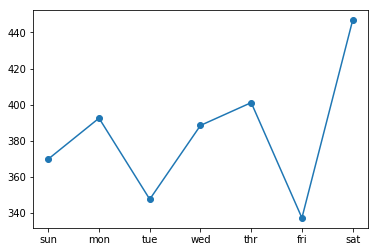

In [12]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='multiheaded_Encoder-Decoder_multivariate.png', show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

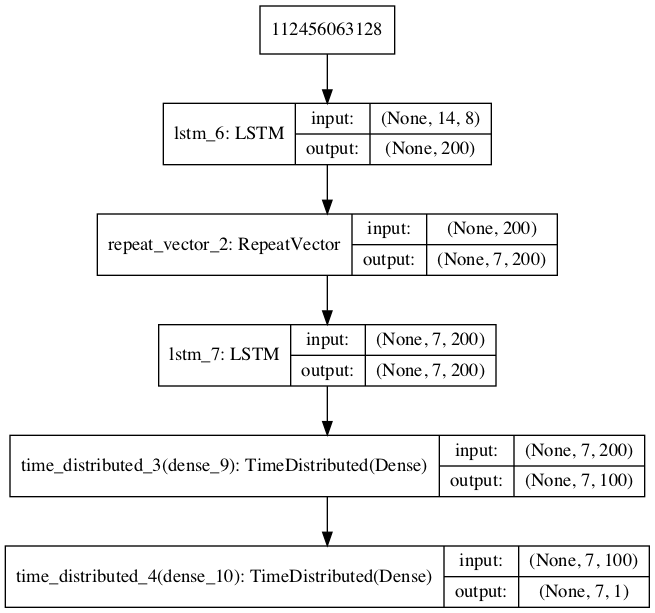

In [13]:
from IPython.display import Image
Image(retina=True, filename='multiheaded_Encoder-Decoder_multivariate.png')

Running the example fits the model and summarizes the performance on the test dataset. Experimentation found that this model appears less stable than the univariate case and may be related to the differing scales of the input eight variables. We can see that in this case, the model is skillful, achieving an overall RMSE score of about 384 kilowatts.


## 20.9 CNN-LSTM Encoder-Decoder With Univariate Input

1. A convolutional neural network, or CNN, can be used as the encoder in an encoder-decoder architecture. The CNN does not directly support sequence input; instead, a 1D CNN is capable of reading across sequence input and automatically learning the salient features. These can then be interpreted by an LSTM decoder as per normal. We refer to hybrid models that use a CNN and LSTM as CNN-LSTM models, and in this case we are using them together in an encoder-decoder architecture. 

2. As before, we will use input sequences comprised of 14 days of daily total power consumption. We will define a simple but effective CNN architecture for the encoder that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened.

3. The first convolutional layer reads across the input sequence and projects the results onto feature maps. The second performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and read the input sequences with a kernel size of three time steps. The max pooling layer simplifies the feature maps by keeping 1 of the values with the largest (max) signal

4. The decoder is the same as was defined in previous sections. The only other change is to set the number of training epochs to 20.

lstm: [373.571] 388.8, 392.8, 334.5, 367.5, 373.0, 306.3, 437.7


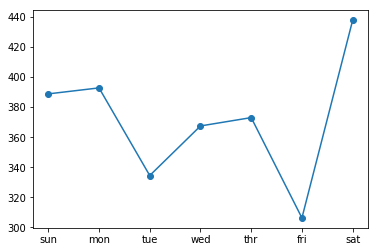

In [15]:
# univariate multi-step encoder-decoder cnn-lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='multiheaded_CNN-LSTM_Encoder-Decoder.png', show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

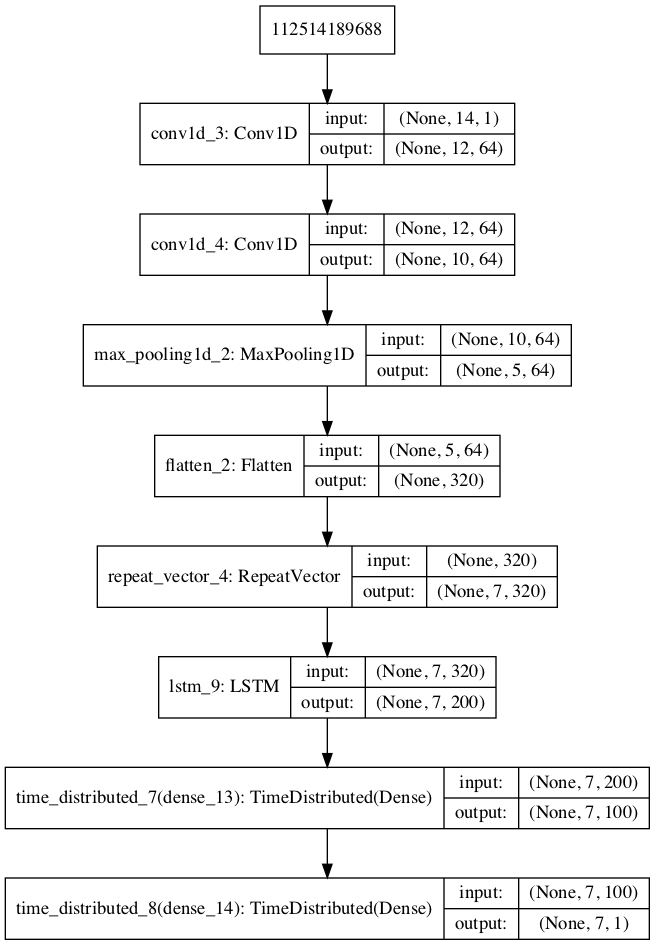

In [17]:
Image(retina=True, filename='multiheaded_CNN-LSTM_Encoder-Decoder.png')

Running the example fits the model and summarizes the performance on the test dataset. A little experimentation showed that using two convolutional layers made the model more stable than using just a single layer. We can see that in this case the model is skillful, achieving an overall RMSE score of about 373 kilowatts.

## 20.10 ConvLSTM Encoder-Decoder With Univariate Input

A further extension of the CNN-LSTM approach is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM for each time step.

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, __the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves__. The Keras library provides the ConvLSTM2D class that supports the ConvLSTM model for 2D data. It can be configured for 1D multivariate time series forecasting. The ConvLSTM2D class, by default, expects input data to have the shape: [samples, timesteps, rows, cols, channels].

we can split the 14 days into two subsequences with a length of
seven days. The ConvLSTM can then read across the two time steps and perform the CNN process on the seven days of data within each. For this chosen framing of the problem, the input for the ConvLSTM2D would therefore be: [n, 2, 1, 7, 1]. Or:
- Samples: n, for the number of examples in the training dataset.
- Time: 2, for the two subsequences that we split a window of 14 days into. 􏰀 
- Rows: 1, for the one-dimensional shape of each subsequence.
- Columns: 7, for the seven days in each subsequence.
- Channels: 1, for the single feature that we are working with as input.

We will also parameterize the number of subsequences (n steps) and the length of each subsequence (n length) and pass them as arguments.

lstm: [374.333] 403.5, 382.7, 337.6, 372.4, 354.4, 303.8, 448.4


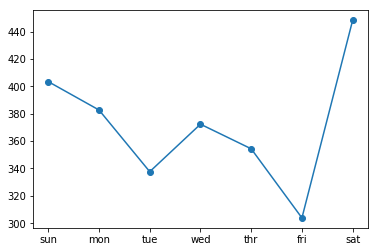

In [21]:
# univariate multi-step encoder-decoder convlstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, timesteps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, show_shapes=True, to_file='multiheaded_convLSTM_Encoder-Decoder.png', show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, timesteps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

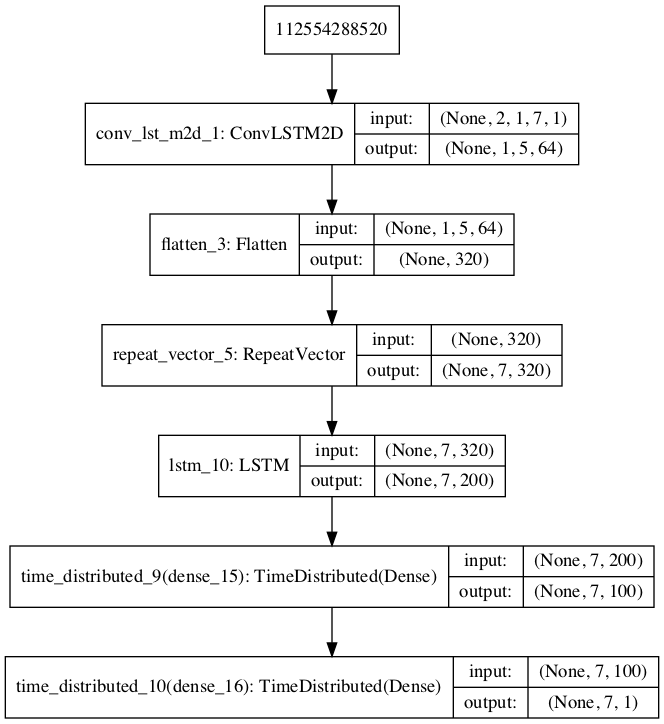

In [19]:
Image(retina=True, filename='multiheaded_convLSTM_Encoder-Decoder.png')

Running the example fits the model and summarizes the performance on the test dataset. A little experimentation showed that using two convolutional layers made the model more stable than using just a single layer. We can see that in this case the model is skillful, achieving an overall RMSE score of about 374 kilowatts.

## 20.12 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- Getting started with the Keras Sequential model. https://keras.io/getting-started/sequential-model-guide/
- Getting started with the Keras functional API. https://keras.io/getting-started/functional-api-guide/
- Keras Sequential Model API. https://keras.io/models/sequential/
- Keras Core Layers API. https://keras.io/layers/core/
- Keras Convolutional Layers API. https://keras.io/layers/convolutional/
- Keras Pooling Layers API. https://keras.io/layers/pooling/
- Keras Recurrent Layers API. https://keras.io/layers/recurrent/

20.13 Summary
In this tutorial, you discovered how to develop long short-term memory recurrent neural networks for multi-step time series forecasting of household power consumption. Specifically, you learned:
- How to develop and evaluate Univariate and multivariate Encoder-Decoder LSTMs for multi-step time series forecasting.
- How to develop and evaluate an CNN-LSTM Encoder-Decoder model for multi-step time series forecasting.
- How to develop and evaluate a ConvLSTM Encoder-Decoder model for multi-step time series forecasting.